In [1]:
import copy
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.utils.data

In [3]:
# DGP related methods
import sys
sys.path.append('../..')

from dsvidgp.kernels import RBF
from dsvidgp.likelihoods import Gaussian
from dsvidgp.layers import SVGPLayer, NNLayer
from dsvidgp.initial_value import calc_median_of_pairwise_distance, calc_centroid

In [4]:
RAND_SEED = 811
torch.manual_seed(RAND_SEED)
np.random.seed(RAND_SEED)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
DATA_SIZE = 50
MINIBATCH_SIZE = 10

HIDDEN_LAYER_DIM = 3
INPUT_DIM = 1
OUTPUT_DIM = 1

# DNN configurations
DNN_HIDDEN_UNITS = 128
DNN_LEARNING_RATE = 0.001
DNN_TRAINING_NUM_EPOCHS = 1000

# GP configurations
NUM_INDUCINGS = 20
GP_LEARNING_RATE = 0.01
LAYERWISE_GP_NUM_EPOCHS = 100
DGP_NUM_EPOCHS = 1000


## Make data

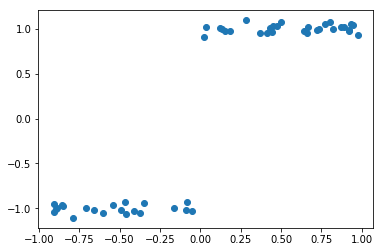

In [7]:

dx = np.random.rand(DATA_SIZE, 1).astype(np.float32) * 2.0 - 1.0
dy = np.where(dx + 0.04 * np.random.randn(*dx.shape) >= 0.0, 1.0, -1.0) \
        + 0.04 * np.random.randn(*dx.shape)
dy = dy.astype(np.float32)

nx = np.linspace(-1.0, 1.0, 200)[:, None]

plt.plot(dx, dy, 'o')

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dx, dy):

        self._N = len(dx)
        self._dx = dx
        self._dy = dy
        
    def __len__(self):
        return self._N
    
    def __getitem__(self, idx):
        return self._dx[idx], self._dy[idx]
    
dataset = Dataset(dx, dy)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=MINIBATCH_SIZE, shuffle=True)


In [9]:
#Plot function
def plot_mean(pred_mean_list, plot_init=False):
    if plot_init:
        plt.plot(nx, pred_mean_list[0], label='init')
    for j in [10, 100, 1000]:
        if j < len(pred_mean_list):
            plt.plot(nx, pred_mean_list[j], label=str(j))
    plt.plot(dx, dy, 'o')
    plt.legend()

## Training method

In [10]:
def train_dgp(optimizer, model, num_epochs):
    lower_bound_list = list()
    pred_mean_list = list()

    tx = torch.from_numpy(nx.astype(np.float32))

    pred_dstr = model.predict(tx.to(device))
    pred_mean_list.append(pred_dstr['mean'].data.cpu().numpy().copy())

    fp = FloatProgress(min=0, max=num_epochs)
    display(fp)

    for i in range(num_epochs):
        fp.value = i
        lower_bound = 0
        
        model.train()
        for b, (x_B, y_B) in enumerate(dataloader):
            x_B = x_B.to(device)
            y_B = y_B.to(device)

            optimizer.zero_grad()

            f_dstr = model(x_B)
            batch_bound = model.calc_bound(y_B, f_dstr)

            loss = -batch_bound  # maximize
            loss.backward()
            
            optimizer.step()

            lower_bound += batch_bound.data.cpu().item()

        lower_bound_list.append(lower_bound)

        model.eval()
        pred_dstr = model.predict(tx.to(device))
        pred_mean_list.append(pred_dstr['mean'].data.cpu().numpy().copy())

    return lower_bound_list, pred_mean_list


In [11]:
def train_dnn(optimizer, model, criterion, num_epochs):
    loss_list = list()
    pred_list = list()

    tx = torch.from_numpy(nx.astype(np.float32))

    pred = model(tx.to(device))
    pred_list.append(pred.data.cpu().numpy().copy())

    fp = FloatProgress(min=0, max=num_epochs)
    display(fp)

    for i in range(num_epochs):
        fp.value = i
        loss_epoch = 0
        
        model.train()
        for b, (x_B, y_B) in enumerate(dataloader):
            x_B = x_B.to(device)
            y_B = y_B.to(device)

            optimizer.zero_grad()
            output = model(x_B)
            loss = criterion(output, y_B)
            loss.backward()
            optimizer.step()

            loss_epoch += loss.data.cpu().item()

        loss_list.append(loss_epoch)

        model.eval()
        pred = model(tx.to(device))
        pred_list.append(pred.data.cpu().numpy().copy())

    return loss_list, pred_list


In [12]:
def train_layerwise_svgp(optimizer, svgp_train_config, dnn, num_epochs):
    lower_bound_list = list()

    fp = FloatProgress(min=0, max=num_epochs)
    display(fp)

    # Make all SVGP models training mode
    for cfg in svgp_train_config:
        cfg['svgp_model'].train()
    dnn.train() # Use dropout to avoid overfitting

    for i in range(num_epochs):
        fp.value = i
        lower_bound = 0
        
        for b, (x_B, y_B) in enumerate(dataloader):
            x_B = x_B.to(device)
            
            optimizer.zero_grad()
            
            # DNN forward propagation 
            with torch.no_grad():
                dnn_hidden_value_dict = dnn.layers_forward(x_B)
            
            bound_list = list()
            for cfg in svgp_train_config:
                svgp = cfg['svgp_model']

                # Use DNN hidden layer values as input and output of Layerwise GP
                layer_input = dnn_hidden_value_dict[cfg['input_key']]
                layer_output = dnn_hidden_value_dict[cfg['output_key']]
                
                f_dstr = svgp(layer_input)
                bound = svgp.calc_bound(layer_output, f_dstr)
                bound_list.append(bound)
            bound_all = sum(bound_list)

            loss = -bound_all
            loss.backward()
            optimizer.step()

            lower_bound += bound.data.cpu().item()

        lower_bound_list.append(lower_bound)

    return lower_bound_list


## Pretraining 1: DNN training

In [13]:
class DNN3(torch.nn.Module):
    """DNN used for pretraining of 3-layer DGP."""
    def __init__(self):
        super().__init__()
        self.layer1 = NNLayer(input_dim=INPUT_DIM,
                              output_dim=HIDDEN_LAYER_DIM,
                              num_hidden_units=DNN_HIDDEN_UNITS)

        self.layer2 = NNLayer(input_dim=HIDDEN_LAYER_DIM,
                              output_dim=HIDDEN_LAYER_DIM,
                              num_hidden_units=DNN_HIDDEN_UNITS)

        self.layer3 = NNLayer(input_dim=HIDDEN_LAYER_DIM,
                              output_dim=OUTPUT_DIM,
                              num_hidden_units=DNN_HIDDEN_UNITS,
                              batch_norm=False)
    
    def forward(self, x):
        h_dict = self.layers_forward(x)
        return h_dict['y']
        
    def layers_forward(self, x):
        """Output all hidden layer values."""
        h1 = self.layer1(x)
        h2 = self.layer2(h1)
        pred = self.layer3(h2)
        
        h_dict = {'x': x, 'h1': h1, 'h2': h2, 'y': pred}
        
        return h_dict
     
dnn_model =  DNN3()
dnn_model

DNN3(
  (layer1): NNLayer(
    (seq): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
      (3): Linear(in_features=128, out_features=3, bias=False)
      (4): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): NNLayer(
    (seq): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
      (3): Linear(in_features=128, out_features=3, bias=False)
      (4): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): NNLayer(
    (seq): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
      (3): Linear(in_features=128, out_features=1, bias=False)
    )
  )
)

In [14]:
optimizer_dnn = torch.optim.Adam(dnn_model.parameters(), lr=DNN_LEARNING_RATE)
loss_dnn_list, pred_mean_dnn_list = train_dnn(
    optimizer=optimizer_dnn,
    model=dnn_model,
    criterion=torch.nn.MSELoss(), num_epochs=DNN_TRAINING_NUM_EPOCHS)

FloatProgress(value=0.0, max=1000.0)

Text(0, 0.5, 'Loss')

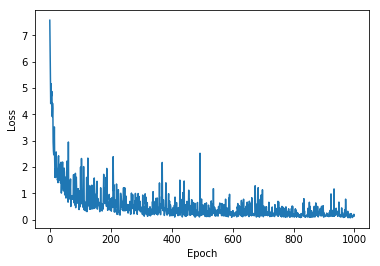

In [15]:
plt.plot(loss_dnn_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')

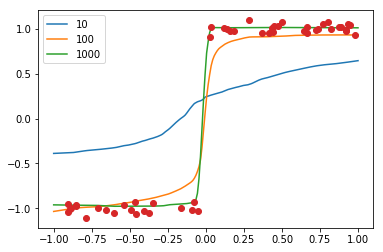

In [16]:
# Plot DNN predition performance
plot_mean(pred_mean_dnn_list)

## Pretraining 2: Layerwise GP training

In [17]:
class SVGP(torch.nn.Module):
    """1-layer Stochastic Variational Gaussian process model."""
    
    def __init__(self, input_dim, output_dim, initial_lengthscale,
                 initial_inducing_input=None,
                 data_size=DATA_SIZE):
        super().__init__()
    
        kern = RBF(input_dim=input_dim,
                   initial_lengthscale=initial_lengthscale)
        self.layer = SVGPLayer(kernel=kern,
                                input_dim=input_dim,
                                output_dim=output_dim,
                                initial_inducing_input=initial_inducing_input,
                                num_inducings=NUM_INDUCINGS,
                                initial_q_S_value=1.0,
                                fix_inducing=False)
        # output
        self.likelihood = Gaussian(output_dim=output_dim,
                                   initial_variance=1e-3)

        self.data_size = data_size

    def forward(self, x):
        return self.layer.pred_mean_and_var(x)
    
    def calc_bound(self, y, f_dstr):
        pe = self.likelihood.predictive_expectation(y, f_dstr)
        
        kld = self.layer.kl_divergence()
        
        batch_size = y.size(0)
        bound = pe  - batch_size / self.data_size * kld
        
        return bound
     
    def predict(self, x):
        f_dstr = self.forward(x)

        y_dstr = self.likelihood.predict(f_dstr)
        return y_dstr


def make_svgp_list():
    lengthscale = calc_median_of_pairwise_distance([dx])
    centroid = calc_centroid(NUM_INDUCINGS, [dx])
    
    svgp1_model = SVGP(INPUT_DIM, HIDDEN_LAYER_DIM, initial_lengthscale=lengthscale,
                       initial_inducing_input=centroid)
    svgp2_model = SVGP(HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM, initial_lengthscale=1.0)
    
    return [svgp1_model, svgp2_model]

svgp_list = make_svgp_list()
svgp_list[0]

SVGP(
  (layer): SVGPLayer(
    input_dim=1, output_dim=3, num_inducings=20
    (kernel): RBF()
  )
  (likelihood): Gaussian()
)

In [18]:
svgp_train_config = [
    {'input_key': 'x', 'output_key': 'h1', 'svgp_model': svgp_list[0]},
    {'input_key': 'h1', 'output_key': 'h2', 'svgp_model': svgp_list[1]},
]

optimizer_svgp_list = torch.optim.Adam(list(svgp_list[0].parameters()) + \
                                       list(svgp_list[1].parameters()),
                                       lr=0.01)
# optimizer_svgp_list.param_groups
lower_bound_list = train_layerwise_svgp(optimizer_svgp_list,
                                        svgp_train_config, dnn_model,
                                        num_epochs=LAYERWISE_GP_NUM_EPOCHS)

FloatProgress(value=0.0)

Text(0, 0.5, 'ELBO')

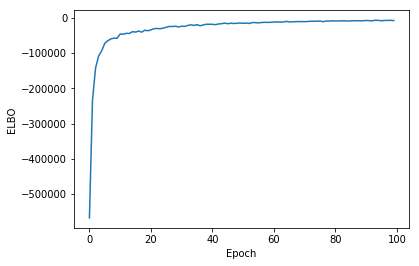

In [19]:
plt.plot(lower_bound_list)
plt.xlabel('Epoch')
plt.ylabel('ELBO')

## Define DGP model

In [20]:
class DGP3(torch.nn.Module):
    """3-layer deep Gaussian process model."""
    
    def __init__(self, layer1, layer2, data_size):
        super().__init__()
    
        # layer 1
        self.layer1 = copy.deepcopy(layer1)
        self.layer1.fix_inducing_(False)

        # layer 2
        self.layer2 = copy.deepcopy(layer2)
        self.layer2.fix_inducing_(True)

        # layer 3
        kern3 = RBF(input_dim=HIDDEN_LAYER_DIM, initial_lengthscale=1.0)
        self.layer3 = SVGPLayer(kernel=kern3,
                                input_dim=HIDDEN_LAYER_DIM,
                                output_dim=OUTPUT_DIM,
                                num_inducings=NUM_INDUCINGS,
                                initial_q_S_value=0.01,
                                fix_inducing=True)

        # output
        self.likelihood = Gaussian(output_dim=OUTPUT_DIM, initial_variance=1e-3)

        self.layers = [self.layer1, self.layer2, self.layer3]
        self.data_size = data_size

    def forward(self, x):
        h1 = self.layer1(x)
        h2 = self.layer2(h1)

        return self.layer3.pred_mean_and_var(h2)
    
    def calc_bound(self, y, f_dstr):
        pe = self.likelihood.predictive_expectation(y, f_dstr)
        
        kld = sum(layer.kl_divergence() for layer in self.layers)
        
        batch_size = y.size(0)
        bound = pe  - batch_size / self.data_size * kld
        
        return bound
     
    def predict(self, x):
        f_dstr = self.forward(x)

        y_dstr = self.likelihood.predict(f_dstr)
        return y_dstr


def make_dgp3():
    model = DGP3(layer1=svgp_list[0].layer,
                 layer2=svgp_list[1].layer,
                 data_size=DATA_SIZE)
    
    return model

dgp_model = make_dgp3()
dgp_model

DGP3(
  (layer1): SVGPLayer(
    input_dim=1, output_dim=3, num_inducings=20
    (kernel): RBF()
  )
  (layer2): SVGPLayer(
    input_dim=3, output_dim=3, num_inducings=20
    (kernel): RBF()
  )
  (layer3): SVGPLayer(
    input_dim=3, output_dim=1, num_inducings=20
    (kernel): RBF()
  )
  (likelihood): Gaussian()
)

In [21]:
optimizer = torch.optim.Adam(dgp_model.parameters(), lr=GP_LEARNING_RATE)
lower_bound_list, pred_mean_list = train_dgp(optimizer, dgp_model, num_epochs=DGP_NUM_EPOCHS)

FloatProgress(value=0.0, max=1000.0)

## Results

Text(0, 0.5, 'ELBO')

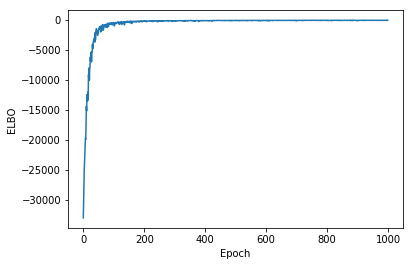

In [22]:
# plotting the change of ELBO
plt.plot(lower_bound_list)
plt.xlabel('Epoch')
plt.ylabel('ELBO')

### plot predicted mean for each epoch

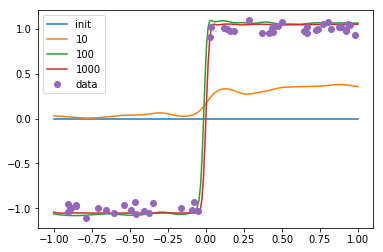

In [23]:
plt.plot(nx, pred_mean_list[0], label='init')
for j in [10, 100, 1000]:
    if j < len(pred_mean_list):
        plt.plot(nx, pred_mean_list[j], label=str(j))
plt.plot(dx, dy, 'o', label='data')
plt.legend()

## plot layer-wise value

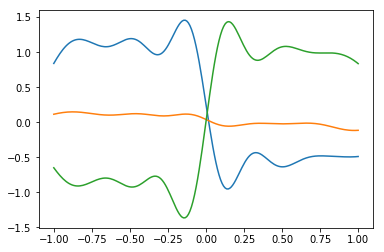

In [24]:
tx = torch.from_numpy(nx.astype(np.float32))
m1 = dgp_model.layer1.pred_mean_and_var(tx)['mean']
plt.plot(nx, m1.data.numpy())

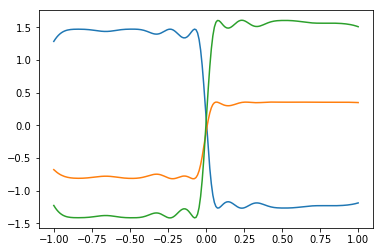

In [25]:
m2 = dgp_model.layer2.pred_mean_and_var(m1)['mean']
plt.plot(nx, m2.data.numpy())

Plot predictive distribution approximated by
$$
\begin{align}
p(y) &= \int p(y | f) q(f | \bar{h}^{(2)}) df \\
\bar{h}^{(2)} &= \mathbb{E}\left[ q(h^{(2)} | \bar{h}^{(1)}) \right] \\
\bar{h}^{(1)} &= \mathbb{E}\left[ q(h^{(1)} | x) \right].
\end{align}
$$


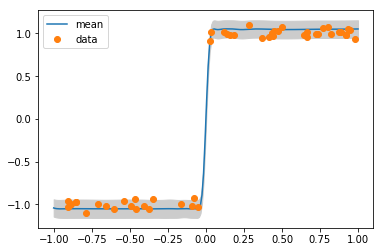

In [26]:
f_dstr = dgp_model.layer3.pred_mean_and_var(m2)
y_dstr = dgp_model.likelihood.predict(f_dstr)
m_y = y_dstr['mean'].data.numpy()
s_y = np.sqrt(y_dstr['var'].data.numpy())
plt.fill_between(nx.ravel(), (m_y + s_y).ravel(), (m_y - s_y).ravel(), color='#cccccc')
plt.plot(nx, m_y, label='mean')
plt.plot(dx, dy, 'o', label='data')
plt.legend()